In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,explained_variance_score
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import os
import pandas as pd
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model


# Data

## Power Consumption data

In [2]:
pjme_df = pd.read_csv('./power_electricity_resampled.csv', parse_dates=[0], index_col=[0])
pjme_df = pjme_df.loc[~pjme_df.index.duplicated(keep='first')].sort_index().dropna()
pjme_df.head()

,electric_power
Datetime,
2017-02-06 07:30:00,26.597063
2017-02-06 08:30:00,30.096608
2017-02-06 09:30:00,30.744339
2017-02-06 10:30:00,30.696277
2017-02-06 11:30:00,29.545297


In [3]:
pjme_df.shape

(11310, 1)

In [4]:
pjme_df.describe()

,electric_power
count,11310.000000
mean,9.306502
std,4.743364
min,5.564006
25%,6.663160
50%,7.435117
75%,9.743601
max,36.533492


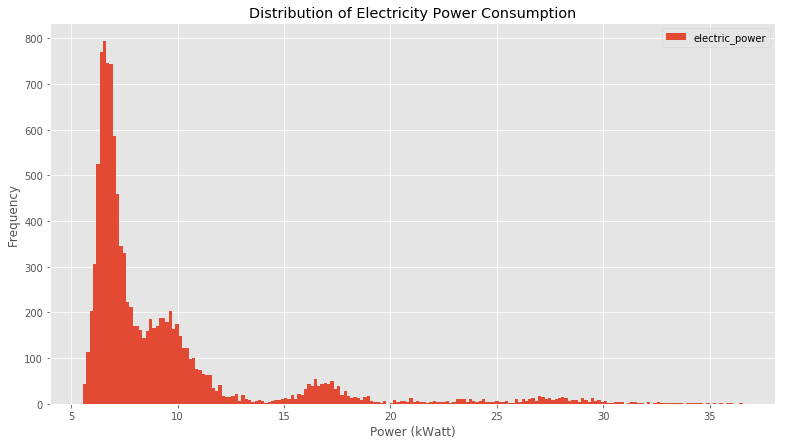

In [5]:
_ = pjme_df.plot.hist(figsize=(13, 7), bins=200, title='Distribution of Electricity Power Consumption')
plt.xlabel('Power (kWatt)')
plt.show()

## Weather Data

### Combine Power and weather data

In [6]:
weather_d = pd.read_csv('./weather.csv', parse_dates=[0], index_col=[0])
weather_d = weather_d.loc[~weather_d.index.duplicated(keep='first')].sort_index().dropna()
weather_d = weather_d.assign(
                                pressure_log = weather_d.Pressure.apply(np.log)
                                )
weather_d.head()

,Temperature,Pressure,Humidity,Wind,Wind_Speed,Forcast,City,pressure_log
Datetime,,,,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,Wind blowing from the west,3.0,Mist.,Falconara,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,Wind blowing from the north-west,8.0,,Falconara,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,Wind blowing from the north-west,7.0,,Falconara,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,Wind blowing from the north-west,8.0,,Falconara,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,Wind blowing from the west-northwest,6.0,Clouds generally dissolving or becoming less d...,Falconara,6.634765


In [7]:
weather_d.drop('Forcast', axis=1, inplace=True)
weather_d.head()

,Temperature,Pressure,Humidity,Wind,Wind_Speed,City,pressure_log
Datetime,,,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,Wind blowing from the west,3.0,Falconara,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,Wind blowing from the north-west,8.0,Falconara,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,Wind blowing from the north-west,7.0,Falconara,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,Wind blowing from the north-west,8.0,Falconara,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,Wind blowing from the west-northwest,6.0,Falconara,6.634765


In [8]:
weather_d.drop('City', axis=1, inplace=True)
weather_d.head()

,Temperature,Pressure,Humidity,Wind,Wind_Speed,pressure_log
Datetime,,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,Wind blowing from the west,3.0,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,Wind blowing from the north-west,8.0,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,Wind blowing from the north-west,7.0,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,Wind blowing from the north-west,8.0,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,Wind blowing from the west-northwest,6.0,6.634765


In [9]:
weather_d.drop('Wind', axis=1, inplace=True)
weather_d.head()

,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,
2017-01-03 05:00:00,15.9,758.1,86.0,3.0,6.630815
2017-01-03 14:00:00,20.4,760.2,64.0,8.0,6.633582
2017-01-03 20:00:00,16.9,761.4,75.0,7.0,6.635159
2017-01-03 23:00:00,16.4,762.3,74.0,8.0,6.636340
2017-01-04 02:00:00,15.8,761.1,78.0,6.0,6.634765


In [10]:

# resample at 1H to average
resample = weather_d.resample('H', loffset='30T').pad()

weather_df = resample.interpolate()

# remove constant points


weather_df.head(50)
weather_df.to_csv('./weather_resampled.csv')

In [11]:
comb_df = pd.concat([pjme_df.loc[weather_df.index[0]:weather_df.index[-1]], weather_df], axis=1).sort_index().dropna()

comb_df.head()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258


In [12]:
comb_df.tail()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,,
2018-10-30 11:30:00,11.071924,27.6,764.3,48.0,4.0,6.63896
2018-10-30 12:30:00,10.741479,27.6,764.3,48.0,4.0,6.63896
2018-10-30 13:30:00,10.163620,27.6,764.3,48.0,4.0,6.63896
2018-10-30 14:30:00,9.992667,27.9,763.2,49.0,5.0,6.63752
2018-10-30 15:30:00,9.924275,27.9,763.2,49.0,5.0,6.63752


### Power and weather data visualization

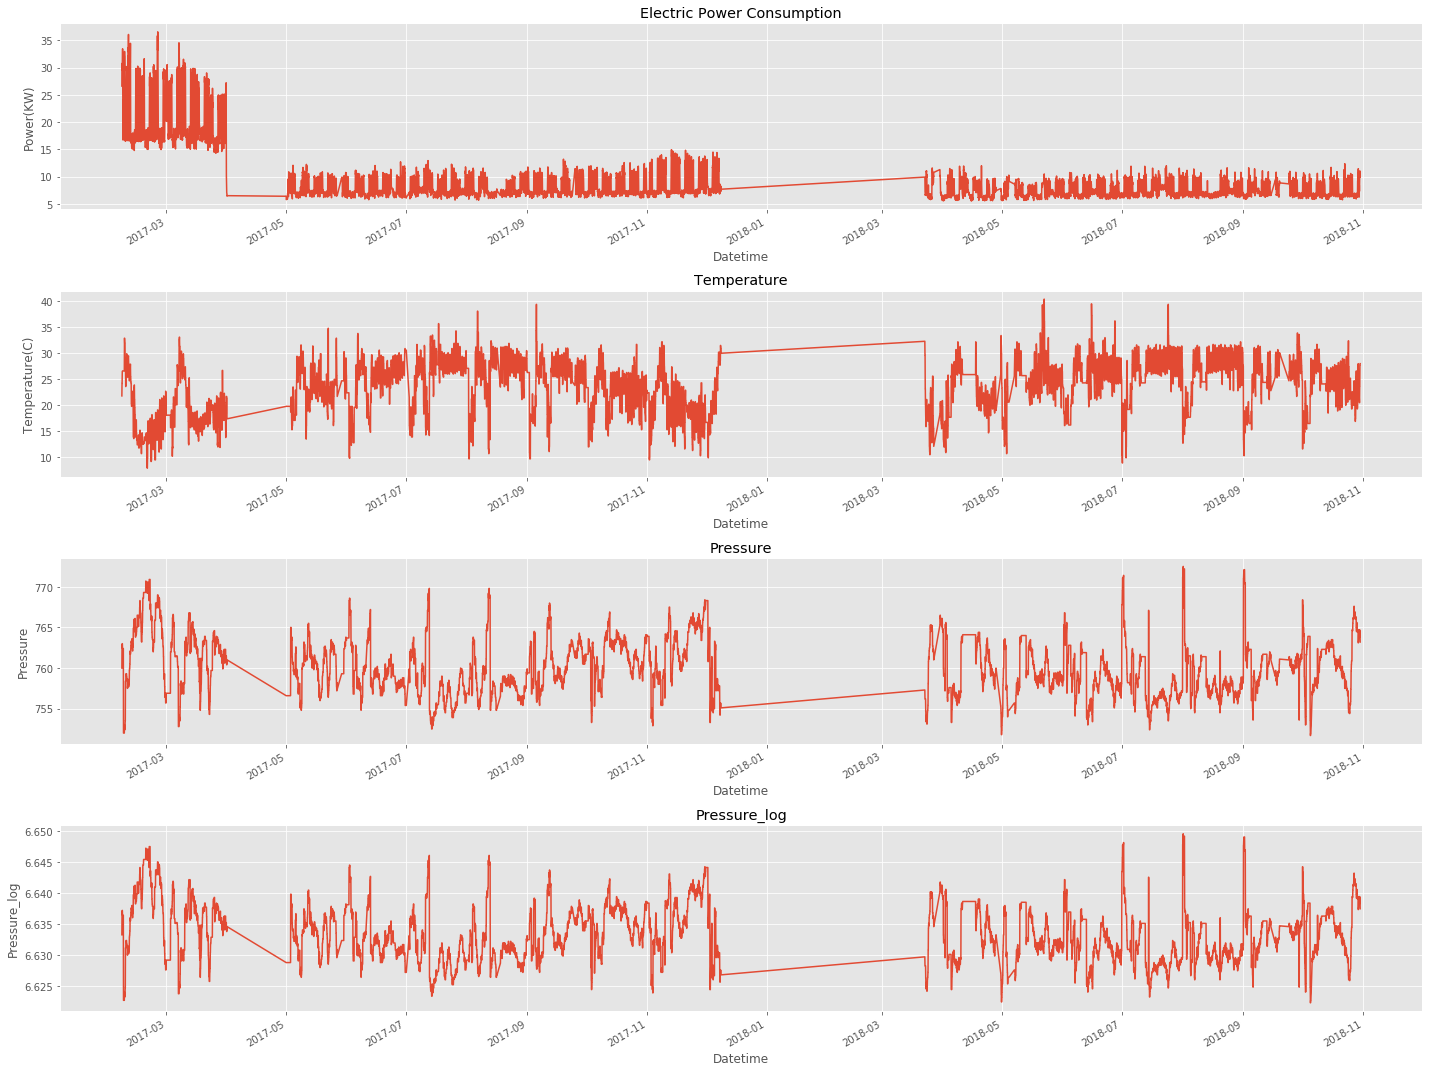

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
axes[0].set_title('Electric Power Consumption')
axes[0].set_ylabel('Power(KW)')
axes[0].set_xlabel('Datetime')
comb_df.electric_power.plot(ax=axes[0])

axes[1].set_title('Temperature')
axes[1].set_ylabel('Temperature(C)')
axes[1].set_xlabel('Datetime')
comb_df.Temperature.plot(ax=axes[1])

axes[2].set_title('Pressure')
axes[2].set_ylabel('Pressure')
axes[2].set_xlabel('Datetime')
comb_df.Pressure.plot(ax=axes[2])

axes[3].set_title('Pressure_log')
axes[3].set_ylabel('Pressure_log')
axes[3].set_xlabel('Datetime')
comb_df.pressure_log.plot(ax=axes[3]                      
                      
                     )

plt.tight_layout()
plt.show()

## Time series features

* Adding time series features.

In [14]:
final_df = (comb_df.assign( day_of_week = comb_df.index.dayofweek
                            ,year = comb_df.index.year
                            ,month = comb_df.index.month
                            ,day = comb_df.index.day
                            ,day_of_year = comb_df.index.dayofyear

                            ,week = comb_df.index.week
                            ,week_day = comb_df.index.weekday_name 
                            ,quarter = comb_df.index.quarter
                            ,hour = comb_df.index.hour
                            ,hour_x = np.sin(2.*np.pi*comb_df.index.hour/24.)
                            ,hour_y = np.cos(2*np.pi*comb_df.index.hour/24.)
                            ,day_of_year_x = np.sin(2.*np.pi*comb_df.index.dayofyear/365.)
                            ,day_of_year_y = np.cos(2.*np.pi*comb_df.index.dayofyear/365.)

                          )
           )

# df['hourfloat']=df.hour+df.minute/60.0
# df['x']=np.sin(2.*np.pi*df.hourfloat/24.)
# df['y']=np.cos(2.*np.pi*df.hourfloat/24.)

In [15]:
final_df.head()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Datetime,,,,,,,,,,,,,,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318,0,2017,2,6,37,6,Monday,1,7,0.965926,-0.258819,0.594727,0.803928
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,8,0.866025,-0.500000,0.594727,0.803928
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,9,0.707107,-0.707107,0.594727,0.803928
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,10,0.500000,-0.866025,0.594727,0.803928
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258,0,2017,2,6,37,6,Monday,1,11,0.258819,-0.965926,0.594727,0.803928


## Features correlation heatmap

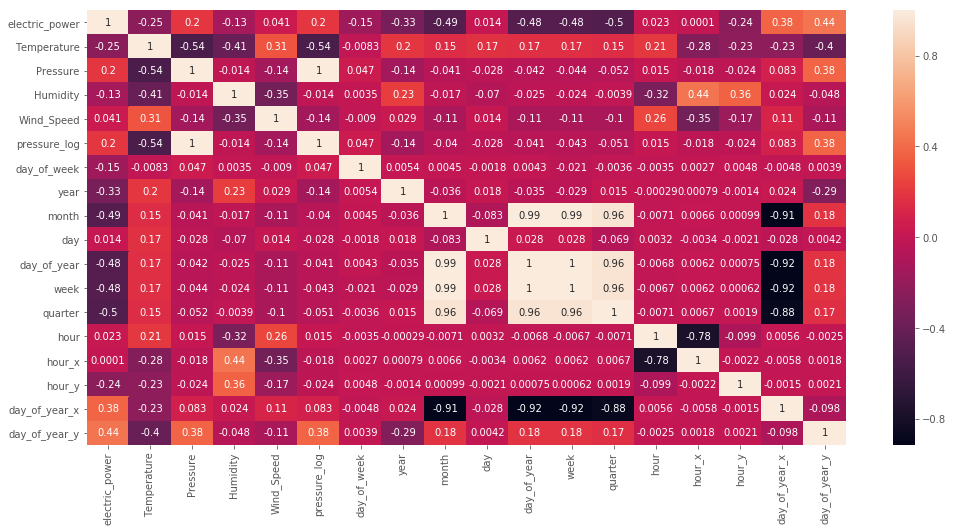

In [16]:
fig, ax = plt.subplots(figsize = (17,8))
corr = final_df.corr()
ax = sns.heatmap(corr, annot=True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)
plt.show()

* **Power consumption** is highly correlated to the **hour**.

## Regression Models

In [17]:
final_df.head()


,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Datetime,,,,,,,,,,,,,,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318,0,2017,2,6,37,6,Monday,1,7,0.965926,-0.258819,0.594727,0.803928
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,8,0.866025,-0.500000,0.594727,0.803928
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,9,0.707107,-0.707107,0.594727,0.803928
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,10,0.500000,-0.866025,0.594727,0.803928
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258,0,2017,2,6,37,6,Monday,1,11,0.258819,-0.965926,0.594727,0.803928


## Lagging features


In [18]:

# Build lagged weather predictors.
# lagged_df = comb_df.loc[comb_df.index.min().ceil('D'):].copy()
lagged_df = final_df.copy()

# Next day's load values.
lagged_df['load_tomorrow'] = lagged_df['electric_power'].shift(-24)    

for day in range(8):
    lagged_df['Temperature_d' + str(day)] = lagged_df.Temperature.shift(24*day)
    lagged_df['Wind_speed_d' + str(day)] = lagged_df.Wind_Speed.shift(24*day)
    lagged_df['humidity_d' + str(day)] = lagged_df.Humidity.shift(24*day)
    lagged_df['pressure_log_d' + str(day)] = lagged_df.pressure_log.shift(24*day)

    
    
    lagged_df['load_d' + str(day)] = lagged_df.electric_power.shift(24*day)

     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['Temperature', 'Wind_Speed', 'Humidity', 'Pressure', 'week_day','electric_power'])
# lagged_df.iloc[50:80]


In [19]:
lagged_df.tail(5)

,pressure_log,day_of_week,year,month,day,day_of_year,week,quarter,hour,hour_x,...,Temperature_d6,Wind_speed_d6,humidity_d6,pressure_log_d6,load_d6,Temperature_d7,Wind_speed_d7,humidity_d7,pressure_log_d7,load_d7
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-10-29 11:30:00,6.639091,0,2018,10,29,302,44,4,11,2.588190e-01,...,22.3,1.0,78.0,6.631211,9.698699,28.7,4.0,52.0,6.632002,10.791823
2018-10-29 12:30:00,6.639091,0,2018,10,29,302,44,4,12,1.224647e-16,...,22.3,1.0,78.0,6.631211,9.538340,28.7,4.0,52.0,6.632002,10.874629
2018-10-29 13:30:00,6.639091,0,2018,10,29,302,44,4,13,-2.588190e-01,...,22.3,1.0,78.0,6.631211,8.993180,28.7,4.0,52.0,6.632002,11.223755
2018-10-29 14:30:00,6.637389,0,2018,10,29,302,44,4,14,-5.000000e-01,...,29.3,4.0,54.0,6.630288,8.663304,28.7,4.0,52.0,6.632002,10.997043
2018-10-29 15:30:00,6.637389,0,2018,10,29,302,44,4,15,-7.071068e-01,...,29.3,4.0,54.0,6.630288,8.668408,28.7,4.0,52.0,6.632002,10.368045


In [20]:
X = lagged_df.drop(columns=['load_tomorrow'])
y = lagged_df['load_tomorrow']

In [21]:
X.shape

(11118, 53)

In [22]:
y.shape

(11118,)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [24]:
y_Train=list(y_train)

In [25]:
def plot_prediction(actual, prediction, start_date, end_date, title, prediction_label):
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, prediction, label=prediction_label)
    plt.ylabel('Power(KW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.xlim(left= start_date, right=end_date)
    plt.show()
    
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One day')
    axes[0].set_ylabel('Power(KW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One week')
    axes[1].set_ylabel('Power(KW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])
    
    axes[2].set_title('Actual vs Prediction - One month')
    axes[2].set_ylabel('Power(KW)')
    axes[2].set_xlabel('Datetime')
    con_df.plot(ax=axes[2])
    axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances( clf, X_train, y_train=None
                             ,top_n=10, figsize=(10,18), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp


In [26]:
model=linear_model.Ridge()
model.fit(X_train,y_train)
y_predict=model.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_ridge=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")

Y_test=model.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_ridge=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_ridge)+" percent in Ridge Regression")
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(model, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Train error = 11.677811405052367 percent in Ridge Regression
Test error = 8.842388460980672 percent in Ridge Regression
Accuracy: 25.45 
[ 0.71465997 -1.72430634 -0.01523311 -0.27713794  0.42859658 -0.23298083
  0.67950013  0.450762    0.71694234  0.73330129 -0.07347513  0.45205678
 -0.27960788  0.01010735  0.70498657  0.75710819  0.61261024  0.50838863
  0.35307774  0.57143661]
R2 Score :0.53 
<function r2_score at 0x000001F14B0989D8>


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

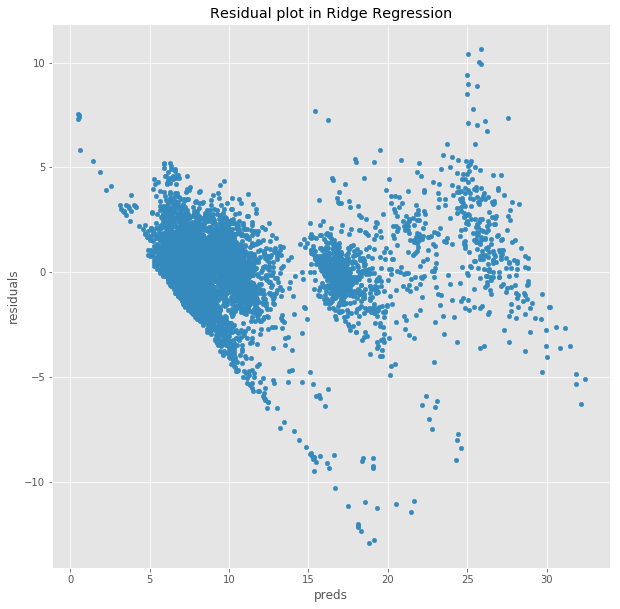

In [27]:
matplotlib.rcParams['figure.figsize'] = (10.0,10.0)

preds = pd.DataFrame({"preds":model.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

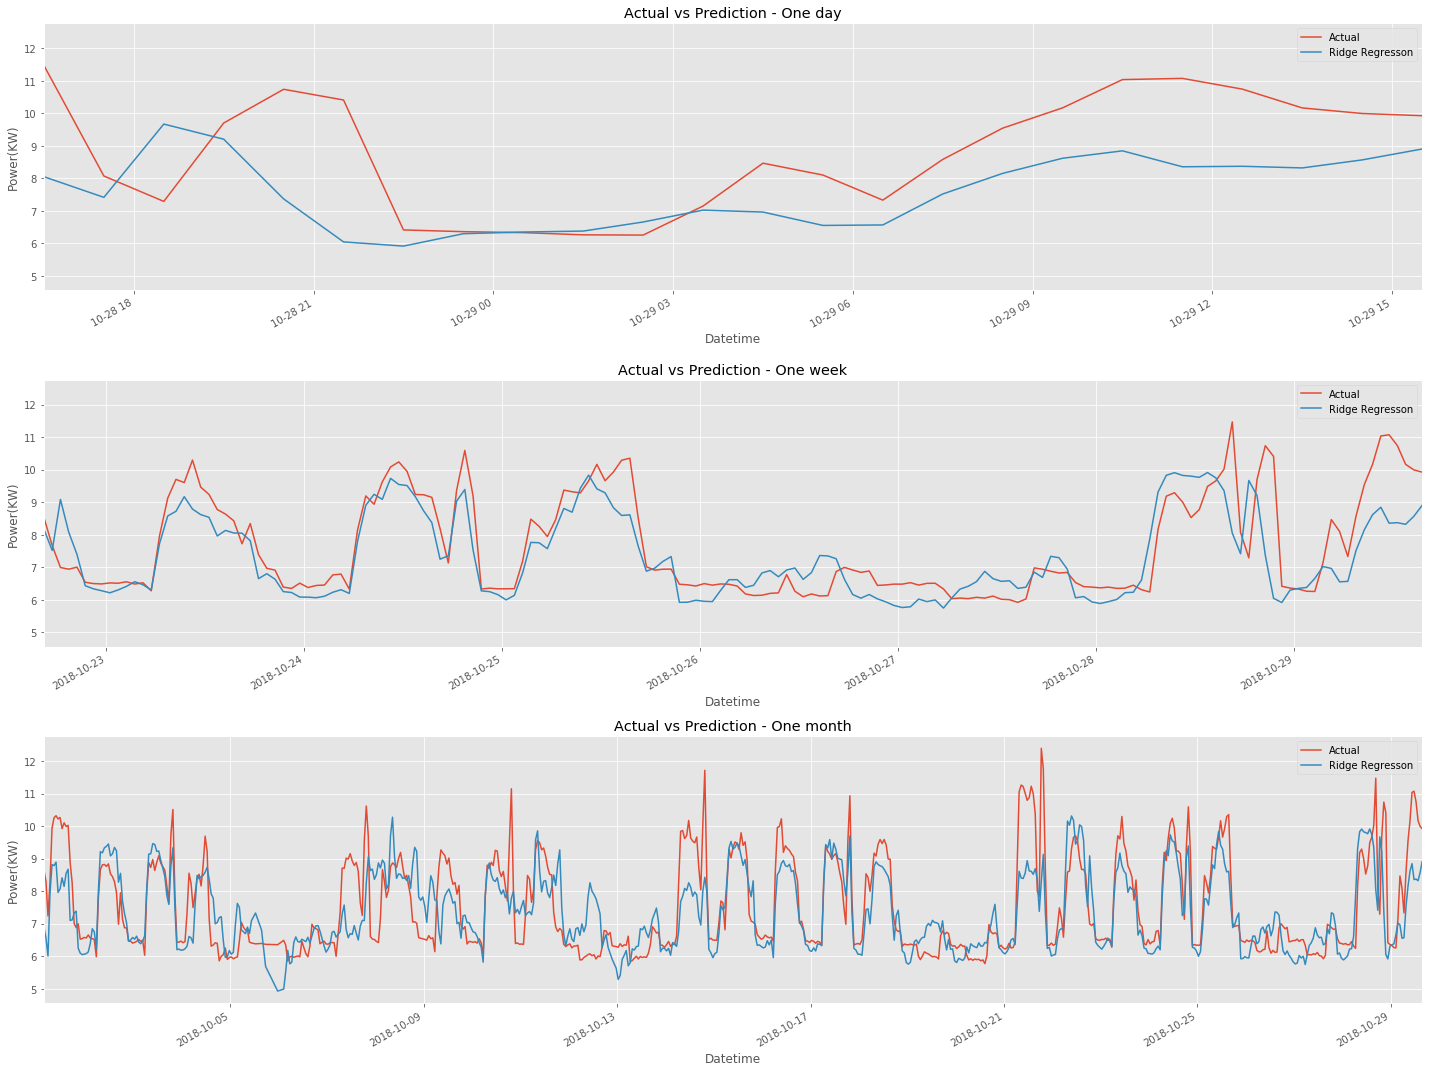

In [28]:
subplot_prediction(y_test, prediction,prediction_label='Ridge Regresson')

In [33]:
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(X_train,y_train)
y1_knn=knn.predict(X_train)
y1_knn=list(y1_knn)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_knn[i]-y_Train[i])/y_Train[i])
train_error_knn=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_knn)+" percent"+" in Knn algorithm")
Y_test=model.predict(X_test)
y2_knn=knn.predict(X_test)
y2_knn=list(y2_knn)
error=0
for i in range(len(y_test)):
    error+=(abs(y2_knn[i]-Y_test[i])/Y_test[i])
test_error_knn=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_knn)+" percent"+" in knn algorithm")
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(knn, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
knn.fit(X_train,y_train)
prediction = knn.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Train error = 6.2216422884308145 percent in Knn algorithm
Test error = 16.321944821241114 percent in knn algorithm
Accuracy: -46.52 
[ 0.57552911 -0.48670646 -0.29138446 -0.14998676 -0.22180052 -0.59167063
 -0.30704101 -0.05030133 -0.50583614  0.19661203 -2.63886725 -2.02271954
 -0.3501583  -0.41829821 -0.41357105 -0.28484849 -0.16774738 -0.29779556
 -0.69102797 -0.18639711]
R2 Score :-0.42 
<function r2_score at 0x000001F14B0989D8>


Text(0.5, 1.0, 'Residual plot in Knn')

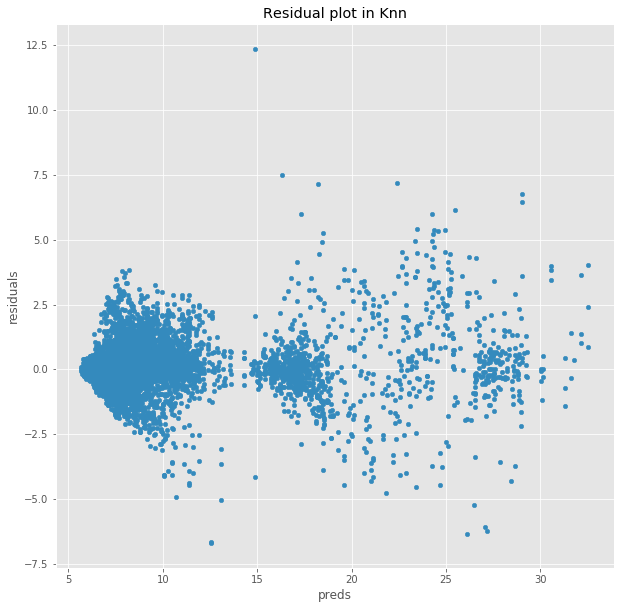

In [34]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
preds = pd.DataFrame({"preds":knn.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Knn")

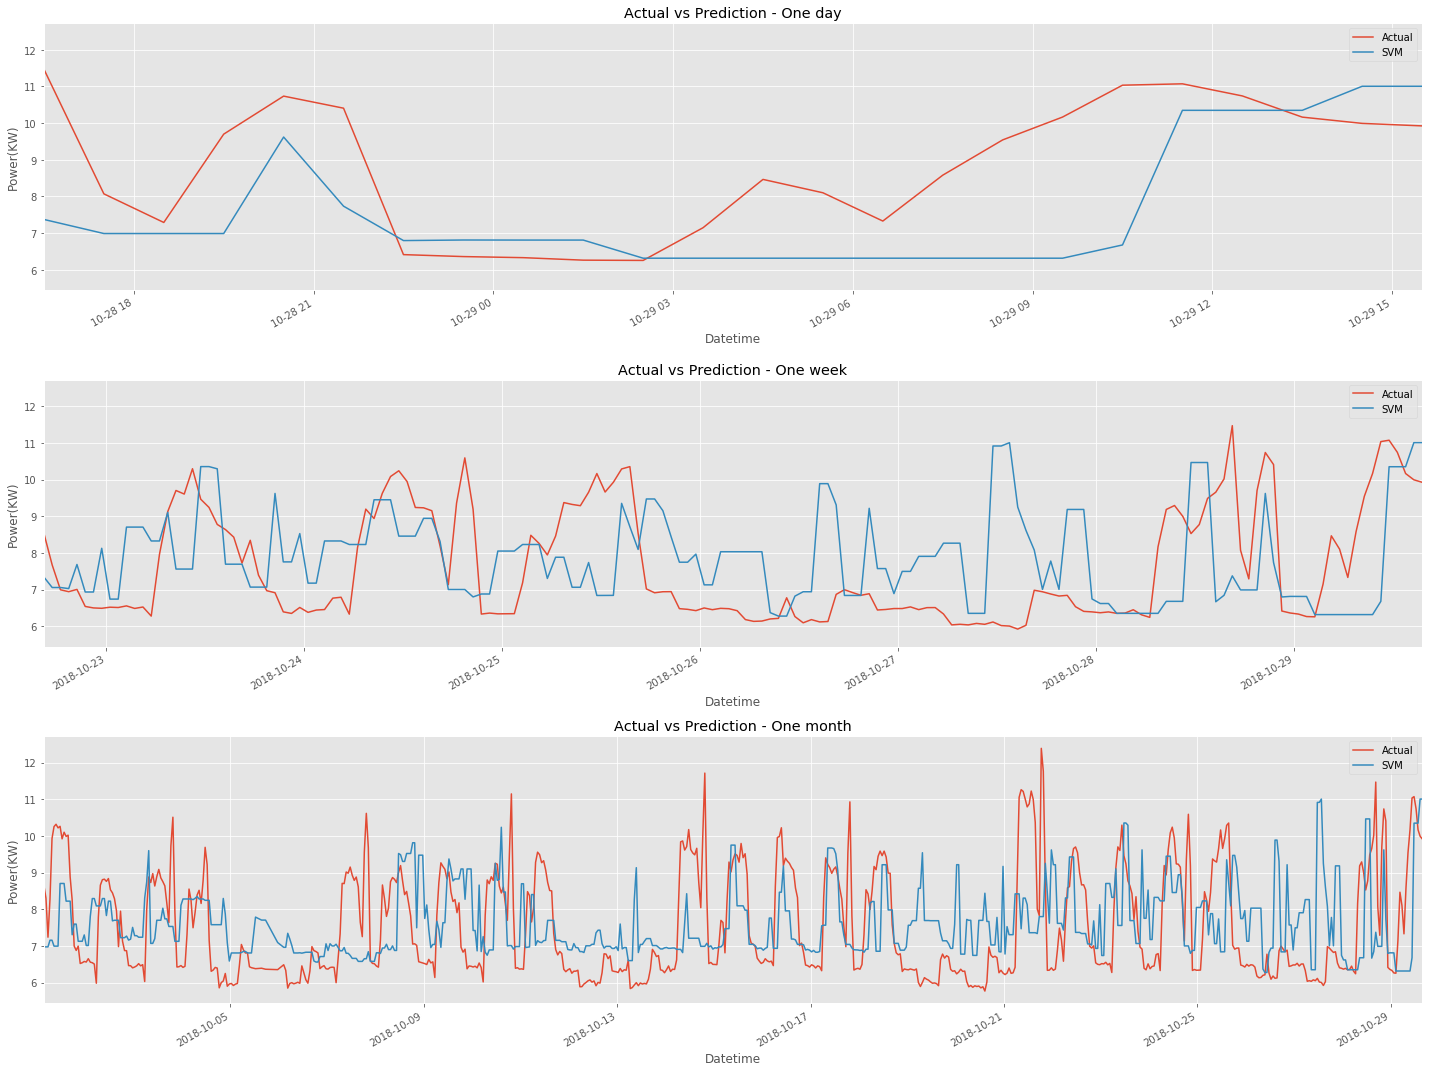

In [35]:
subplot_prediction(y_test, prediction,prediction_label='SVM')

In [37]:
reg = linear_model.BayesianRidge()
reg.fit(X_train,y_train)
y1_reg=reg.predict(X_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(X_test)
y2_reg=list(y2_reg)
Y_test=model.predict(X_test)
Y_test=list(Y_test)
error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_Train[i])/y_Train[i])
train_error_bay=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-Y_test[i])/Y_test[i])
test_error_bay=(error/len(Y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Train error = 11.642169243113928 percent in Bayesian Regression
Test error = 0.670628021662574 percent in Bayesian Regression
Accuracy: 26.55 
[ 0.7856477  -1.73331187  0.03242521 -0.39593621  0.50765214 -0.22804506
  0.68630766  0.49235027  0.73206913  0.74024405 -0.02654842  0.4506351
 -0.2702767   0.01753725  0.71577454  0.75588468  0.6161065   0.50519053
  0.35415736  0.57166857]
R2 Score :0.54 
<function r2_score at 0x000001F14B0989D8>


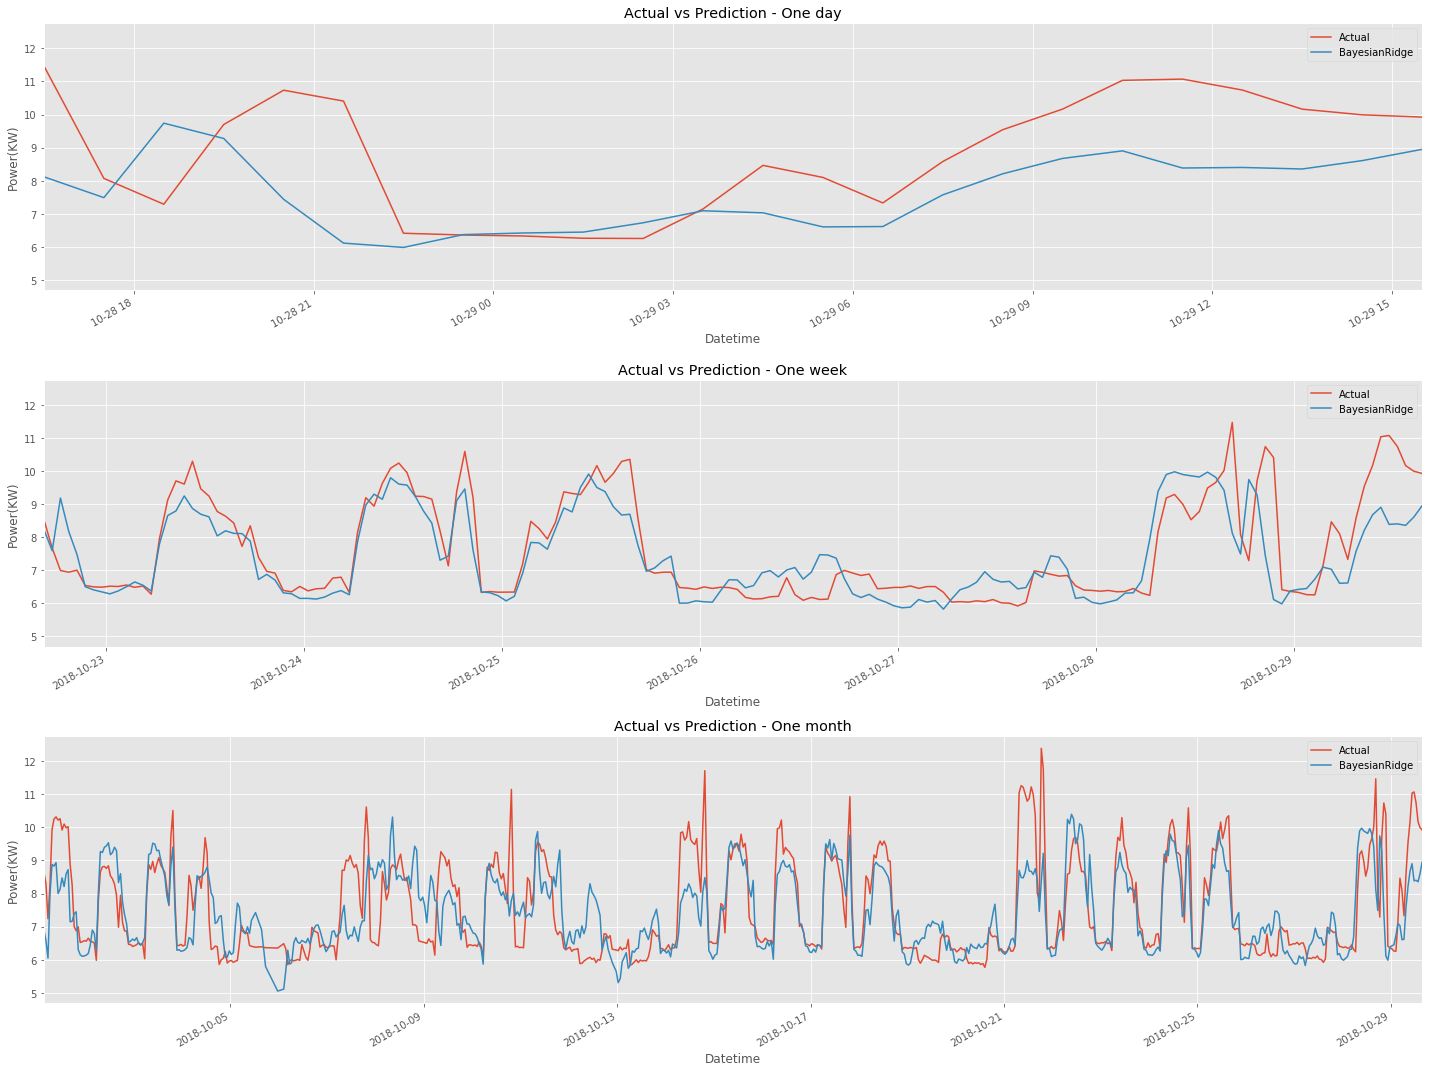

In [38]:
subplot_prediction(y_test, prediction,prediction_label='BayesianRidge')

Text(0.5, 1.0, 'Residual plot in Bayesian Regression')

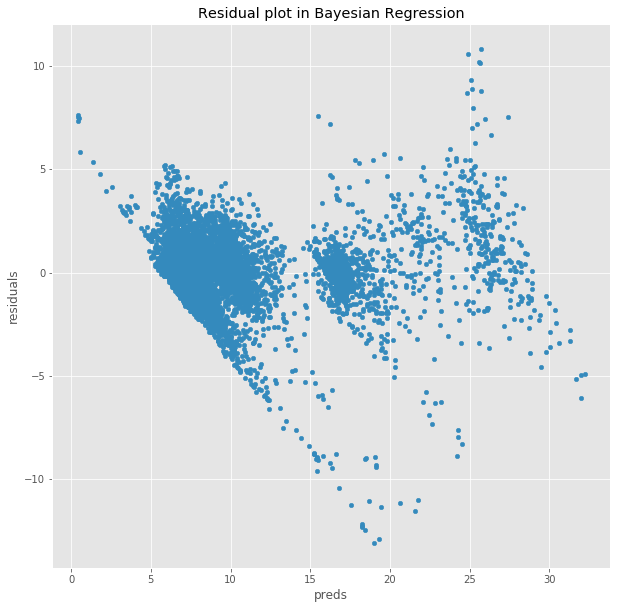

In [39]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
preds = pd.DataFrame({"preds":reg.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [40]:
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(X_train,y_train)
y1_dec=dec.predict(X_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(X_test)
y2_dec=list(y2_dec)
Y_test=model.predict(X_test)
error=0
for i in range(len(y_train)):
    error+=(abs(y1_dec[i]-y_Train[i])/y_Train[i])
train_error_tree=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_tree)+" percent"+" in Decision Tree Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y1_dec[i]-Y_test[i])/Y_test[i])
test_error_tree=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_tree)+" percent in Decision Tree Regressor")

scores = cross_val_score(dec, X.values, y.values, cv=2
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
dec.fit(X_train,y_train)
prediction = dec.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Train error = 18.79285166405813 percent in Decision Tree Regressor
Test error = 75.52178825957927 percent in Decision Tree Regressor
Accuracy: -63.47 
[ 0.17362843 -1.44302746]
R2 Score :-0.08 
<function r2_score at 0x000001F14B0989D8>


Text(0.5, 1.0, 'Residual plot in Decision Tree')

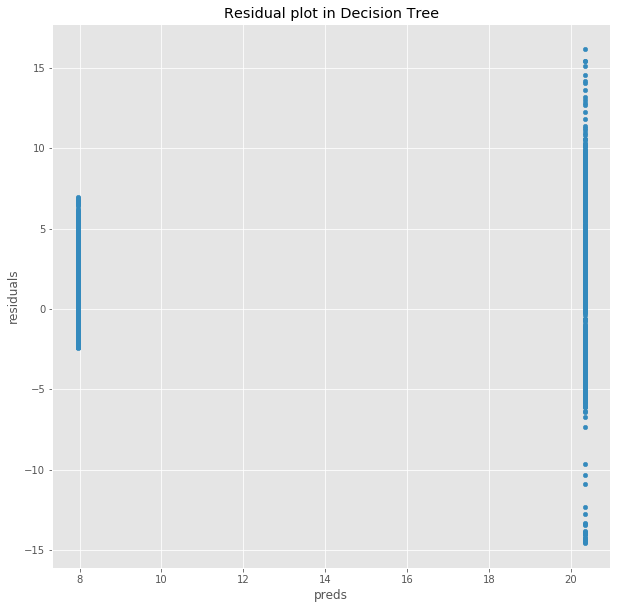

In [41]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
preds = pd.DataFrame({"preds":dec.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

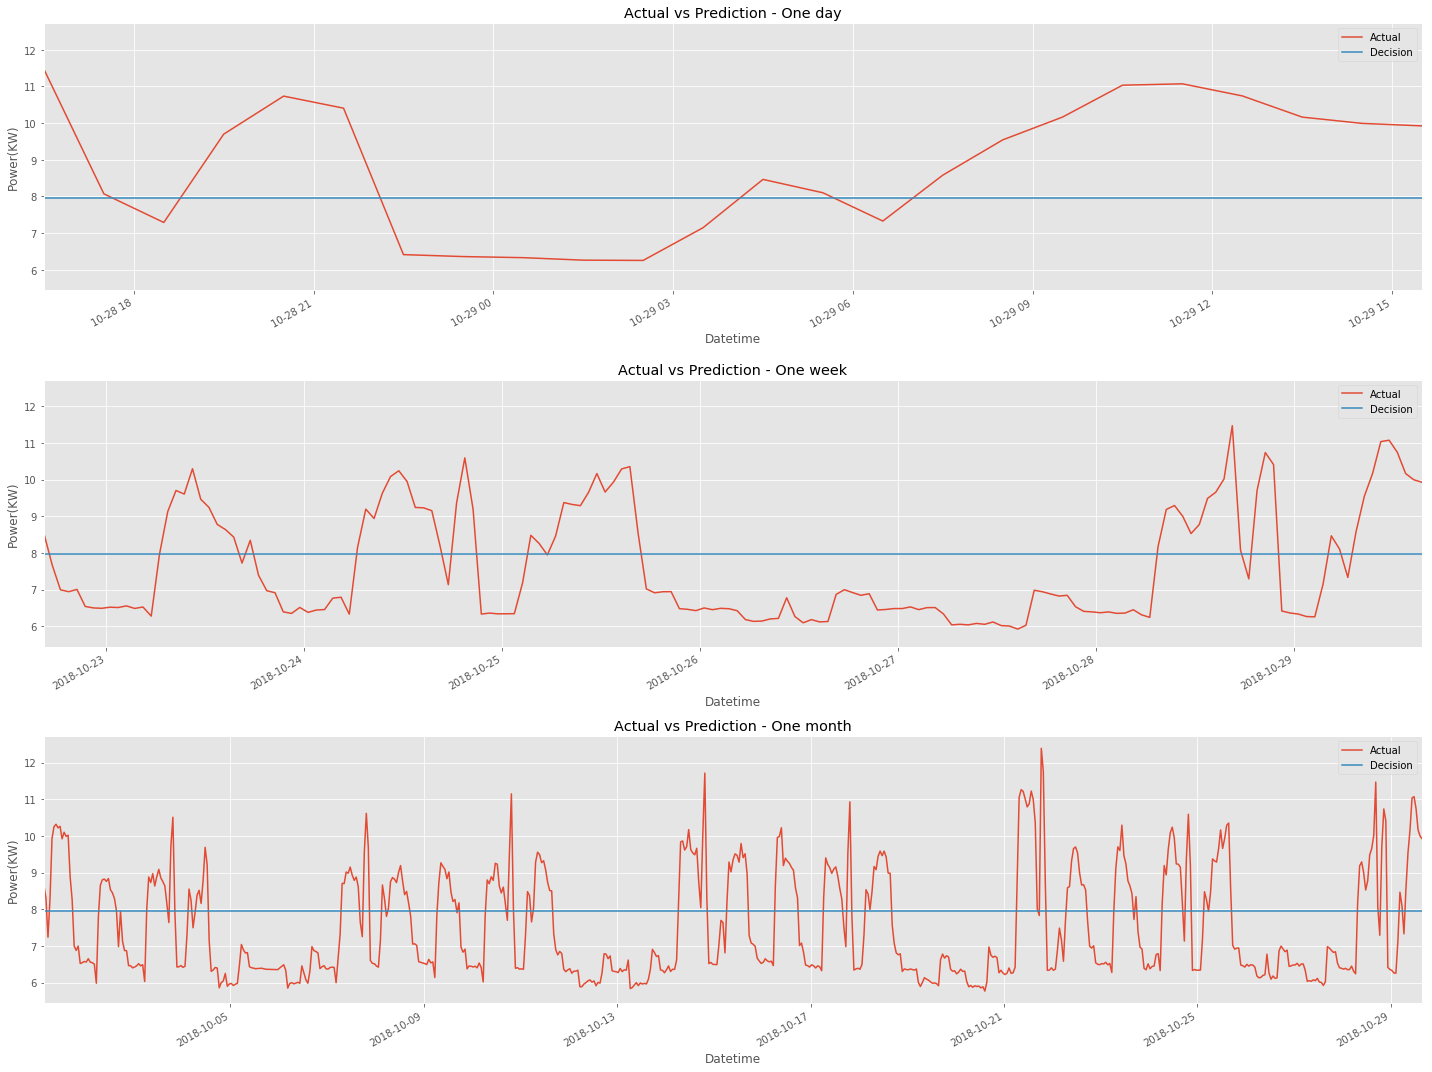

In [42]:
subplot_prediction(y_test, prediction,prediction_label='Decision')

In [43]:
svm_reg=svm.SVR()
svm_reg.fit(X_train,y_train)
y1_svm=svm_reg.predict(X_train)
y1_svm=list(y1_svm)
y2_svm=svm_reg.predict(X_test)
y2_svm=list(y2_svm)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_svm[i]-y_Train[i])/y_Train[i])
train_error_svm=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_svm)+" percent"+" in SVM Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_svm[i]-Y_test[i])/Y_test[i])
test_error_svm=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_svm)+" percent in SVM Regressor")
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(svm_reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)
svm_reg.fit(X_train,y_train)
prediction = svm_reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))
print(r2_score)

Train error = 10.202784424920067 percent in SVM Regressor
Test error = 18.66015891227931 percent in SVM Regressor
Accuracy: 0.11 
[ 2.26770376e-04  1.43077623e-03  1.26539714e-03  1.44156951e-04
 -4.32071838e-03 -8.23788093e-06  2.26516524e-03  4.47183737e-04
  3.10304361e-06  1.62717405e-03  8.76370414e-04  5.82223560e-06
 -7.67040983e-04  4.25931354e-03  5.68674914e-04  2.34268646e-03
  2.42431580e-03  7.68613194e-03 -1.26634139e-04  7.80638350e-04]
R2 Score :-0.20 
<function r2_score at 0x000001F14B0989D8>


In [114]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
preds = pd.DataFrame({"preds":svm_reg.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in SVM")

ValueError: X.shape[1] = 17 should be equal to 53, the number of features at training time

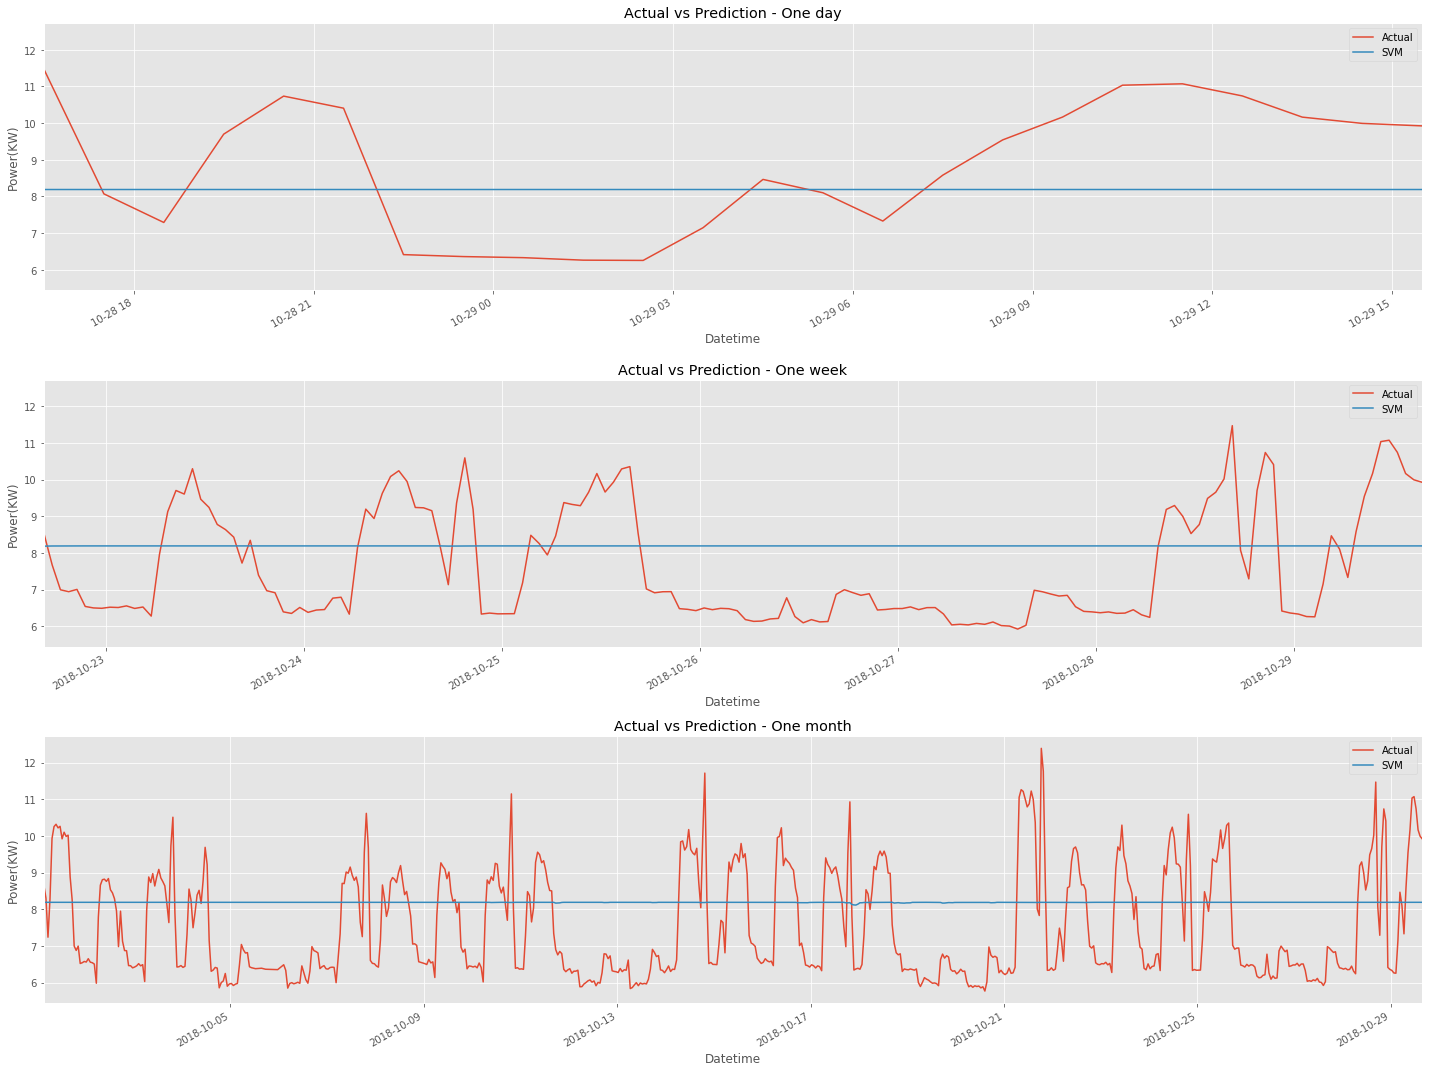

In [45]:
subplot_prediction(y_test, prediction,prediction_label='SVM')

In [46]:
train_error=[train_error_ridge,train_error_knn,train_error_bay,train_error_tree,train_error_svm]
test_error=[test_error_ridge,test_error_knn,test_error_bay,test_error_tree,test_error_svm]

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Bayesian Regression','Decision Tree','SVM']
df=DataFrame(data=col,index=models)
df

,Train Error,Test Error
Ridge Regression,11.677811,8.842388
Knn,6.221642,16.321945
Bayesian Regression,11.642169,0.670628
Decision Tree,18.792852,75.521788
SVM,10.202784,18.660159


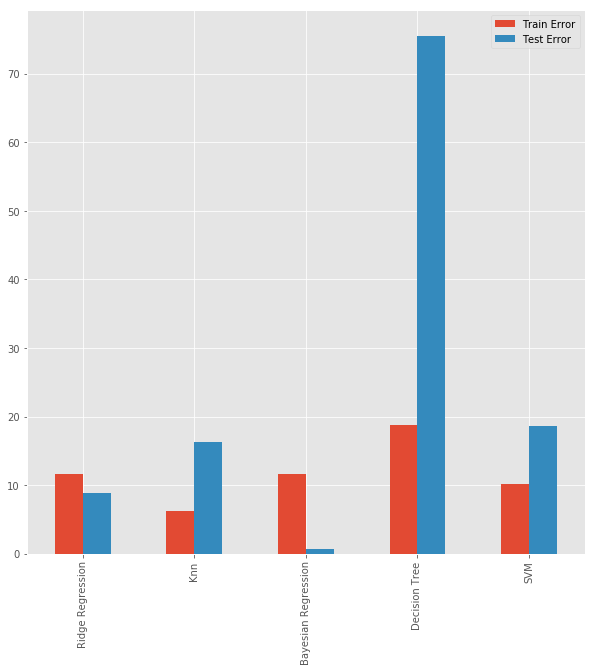

In [47]:
df.plot(kind='bar')

In [48]:
X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)

Text(0, 0.5, 'Cumulative explained variance')

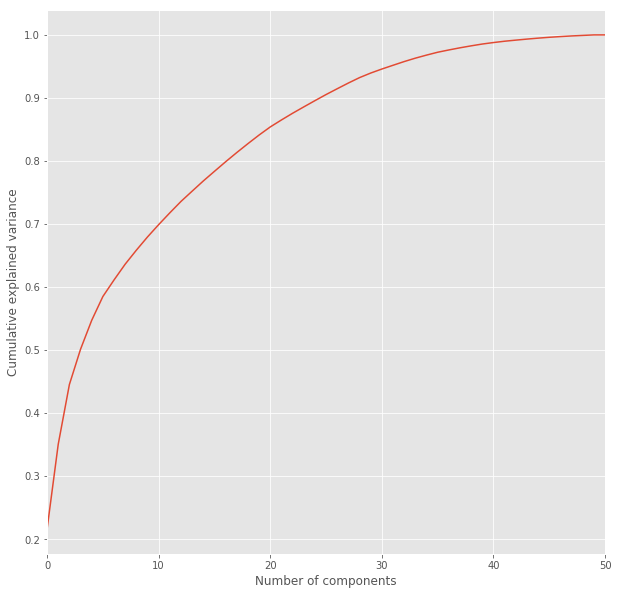

In [49]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,50,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

(-10, 10)

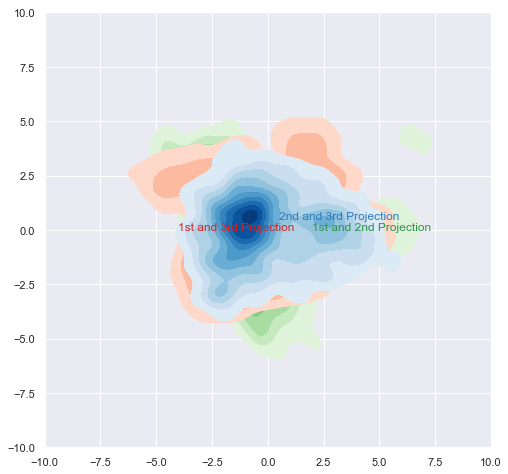

In [50]:
from sklearn.decomposition import PCA
sklearn_pca=PCA(n_components=5)
X_Train=sklearn_pca.fit_transform(X_std)

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(8, 8))
# ax.set_aspect('equal')
ax = sns.kdeplot(X_Train[:,0], X_Train[:,1], cmap="Greens",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,1], X_Train[:,2], cmap="Reds",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,2], X_Train[:,3], cmap="Blues",
          shade=True, shade_lowest=False)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.5, 0.5, "2nd and 3rd Projection", size=12, color=blue)
ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
plt.xlim(-10,10)
plt.ylim(-10,10)

In [51]:
reg = xgb.XGBRegressor()
reg.fit(X_train,y_train)
y_predict=reg.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_XGB=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_XGB)+" percent in XGB Regression")

Y_test=reg.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_XGB=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_XGB)+" percent in XGB Regression")

[00:00:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train error = 6.903321669018073 percent in XGB Regression
Test error = 9.132126237916388 percent in XGB Regression


In [74]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)

Accuracy: 38.03 
[ 0.8355741  -0.09942191  0.31565337  0.86452529  0.71322977  0.44578624
  0.18099672 -0.56782421  0.89660878  0.67948765 -1.63015751  0.29641661
  0.53305242  0.71958122  0.65665218  0.76958508  0.47099386  0.15806692
  0.57483288  0.79257636]


In [75]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))



R2 Score :0.60 


In [76]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__, print_table=True)


AttributeError: 'BaggingRegressor' object has no attribute 'feature_importances_'

In [77]:
comb_df.head()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258


In [78]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
        features['Temperature_d' + str(day)] = comb_df.Temperature.shift(24*day)
        features['Wind_Speed_d' + str(day)] = comb_df.Wind_Speed.shift(24*day)
        features['Humidity_d' + str(day)] = comb_df.Humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)



        features['load_d' + str(day)] = comb_df.electric_power.shift(24*day)

    features = features.dropna()
    
    features = features.drop(columns=['Temperature', 'Wind_Speed', 'Humidity', 'Pressure', 'electric_power'])

    return features




In [79]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
        features['Temperature_d' + str(day)] = comb_df.Temperature.shift(24*day)
        features['Wind_speed_d' + str(day)] = comb_df.Wind_Speed.shift(24*day)
        features['Humidity_d' + str(day)] = comb_df.Humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)



        features['load_d' + str(day)] = comb_df.electric_power.shift(24*day)

    features = features.dropna()
    
    features = features.drop(columns=['Temperature', 'Wind_Speed', 'Humidity', 'Pressure','electric_power'])

    return features




# Regression Models

In [80]:
X = final_df.drop(columns = ['electric_power','week_day'])
y = final_df['electric_power']

In [81]:
X.shape

(11310, 17)

In [82]:
y.shape

(11310,)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## XGB Model


In [84]:
reg = xgb.XGBRegressor()


In [85]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)

[00:09:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [86]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))


[00:09:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Score :0.48 


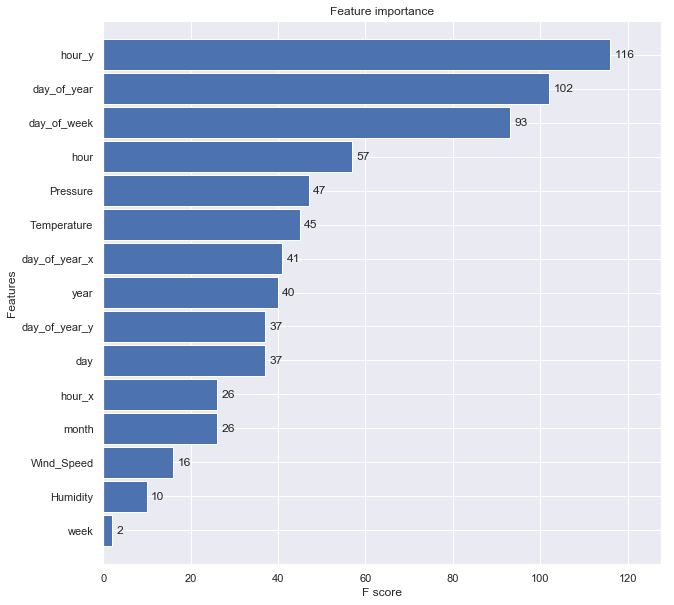

In [87]:
_ = plot_importance(reg, height=0.9)

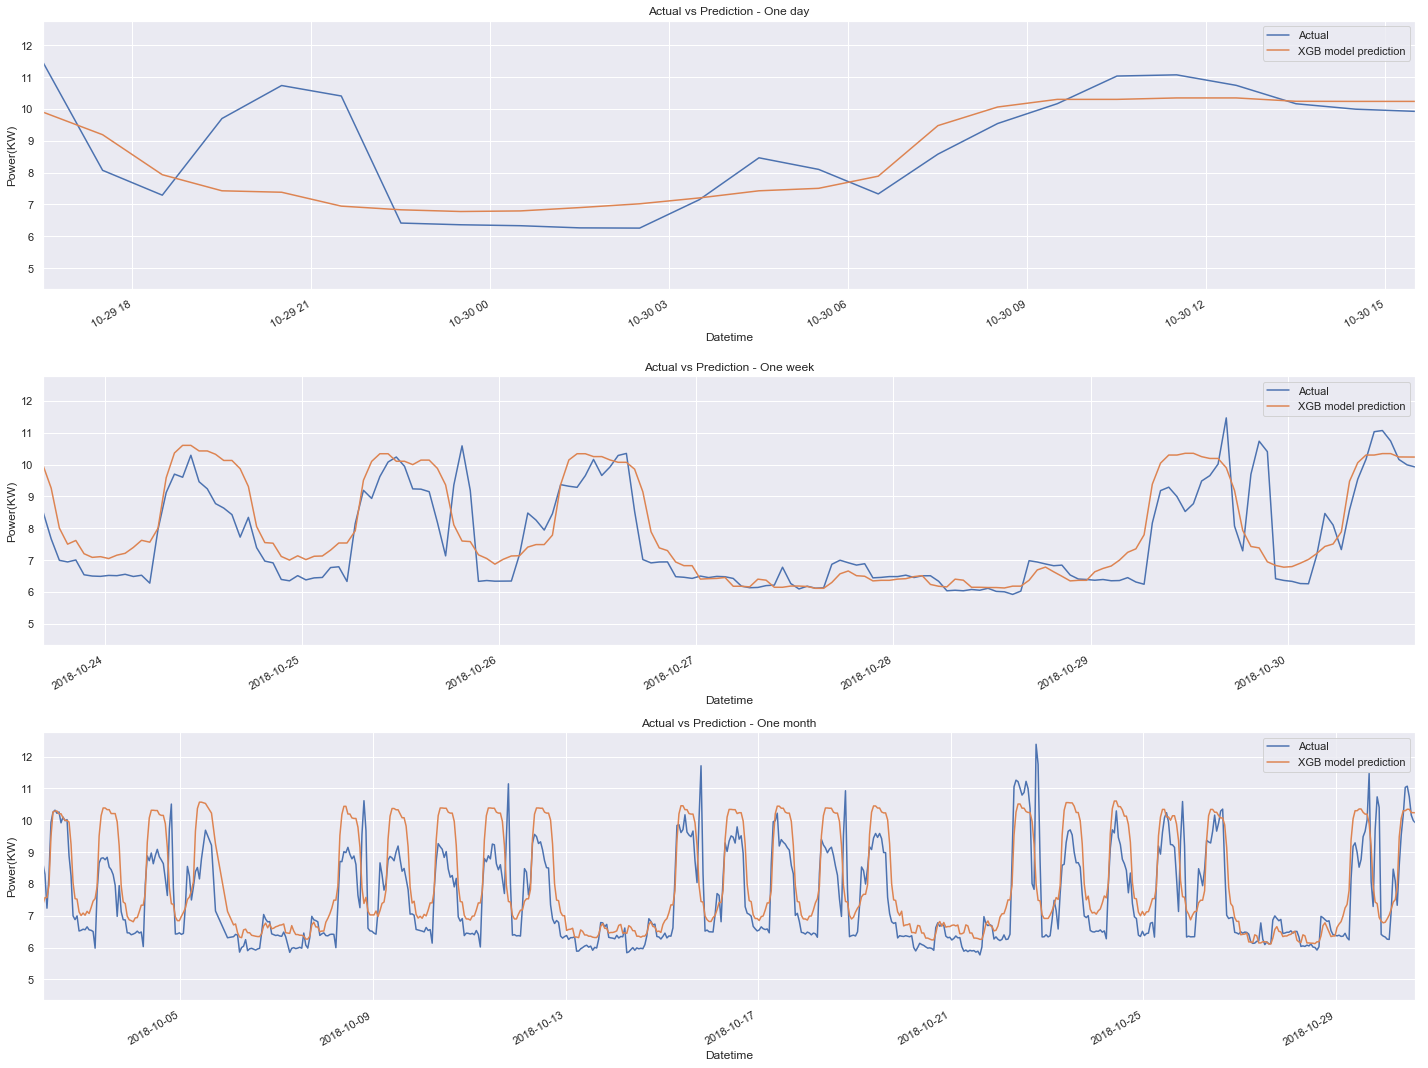

In [88]:
subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')

# AdaBoost Model

In [67]:
reg = AdaBoostRegressor()
reg.fit(X_train,y_train)
y_predict=reg.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_AXGB=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_AXGB)+" percent in XGB Regression")

Y_test=reg.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_AXGB=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_AXGB)+" percent in XGB Regression")

Train error = 23.337574547603054 percent in XGB Regression
Test error = 14.295279262262337 percent in XGB Regression


In [89]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)

[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [90]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

[00:10:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Score :0.48 


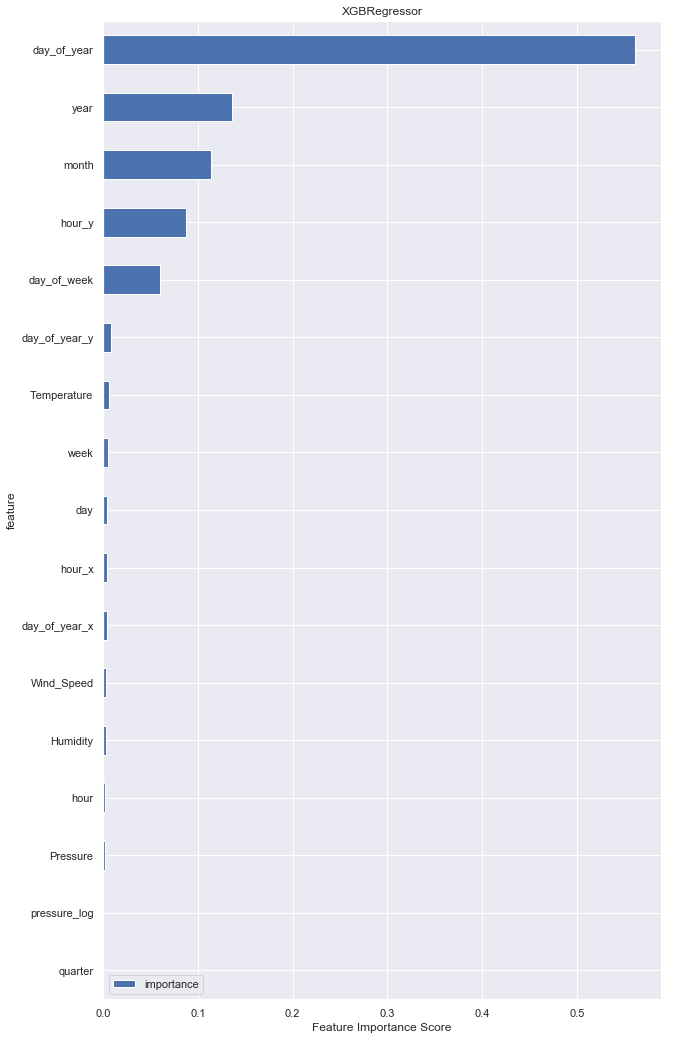

In [91]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

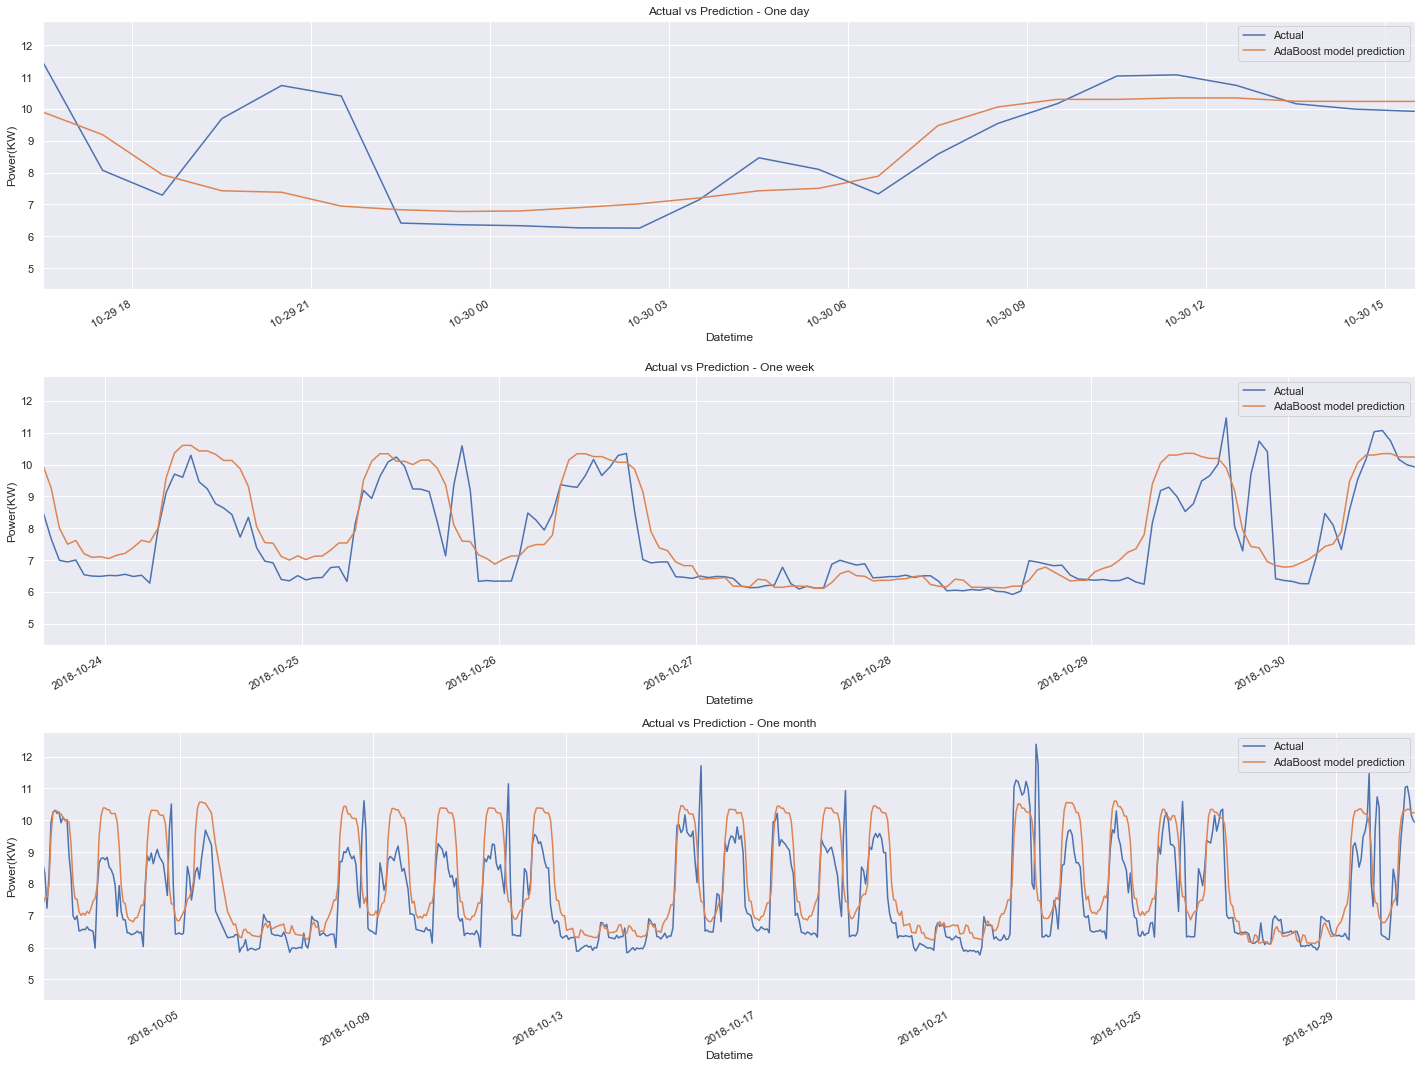

In [92]:
subplot_prediction(y_test, prediction,prediction_label='AdaBoost model prediction')

# Bagging Regressor Model

In [95]:
X.shape

(11310, 17)

In [96]:
y.shape

(11310,)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [98]:
reg = BaggingRegressor()
reg.fit(X_train,y_train)
y_predict=reg.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_BXGB=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_BXGB)+" percent in BXGB Regression")

Y_test=reg.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_BXGB=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_BXGB)+" percent in BXGB Regression")


Train error = 19.706787859437387 percent in BXGB Regression
Test error = 7.891071035517492 percent in BXGB Regression


In [99]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)

Accuracy: 20.37 
[ 0.82378452 -0.21701447  0.25398852  0.86655477  0.70203217  0.40146526
  0.17803631 -3.69307261  0.89022362  0.66972591 -1.88432284  0.43537512
  0.49286521  0.6708912   0.66492107  0.70839644  0.59788799  0.21985828
  0.50870236  0.78318403]


In [100]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

R2 Score :0.54 


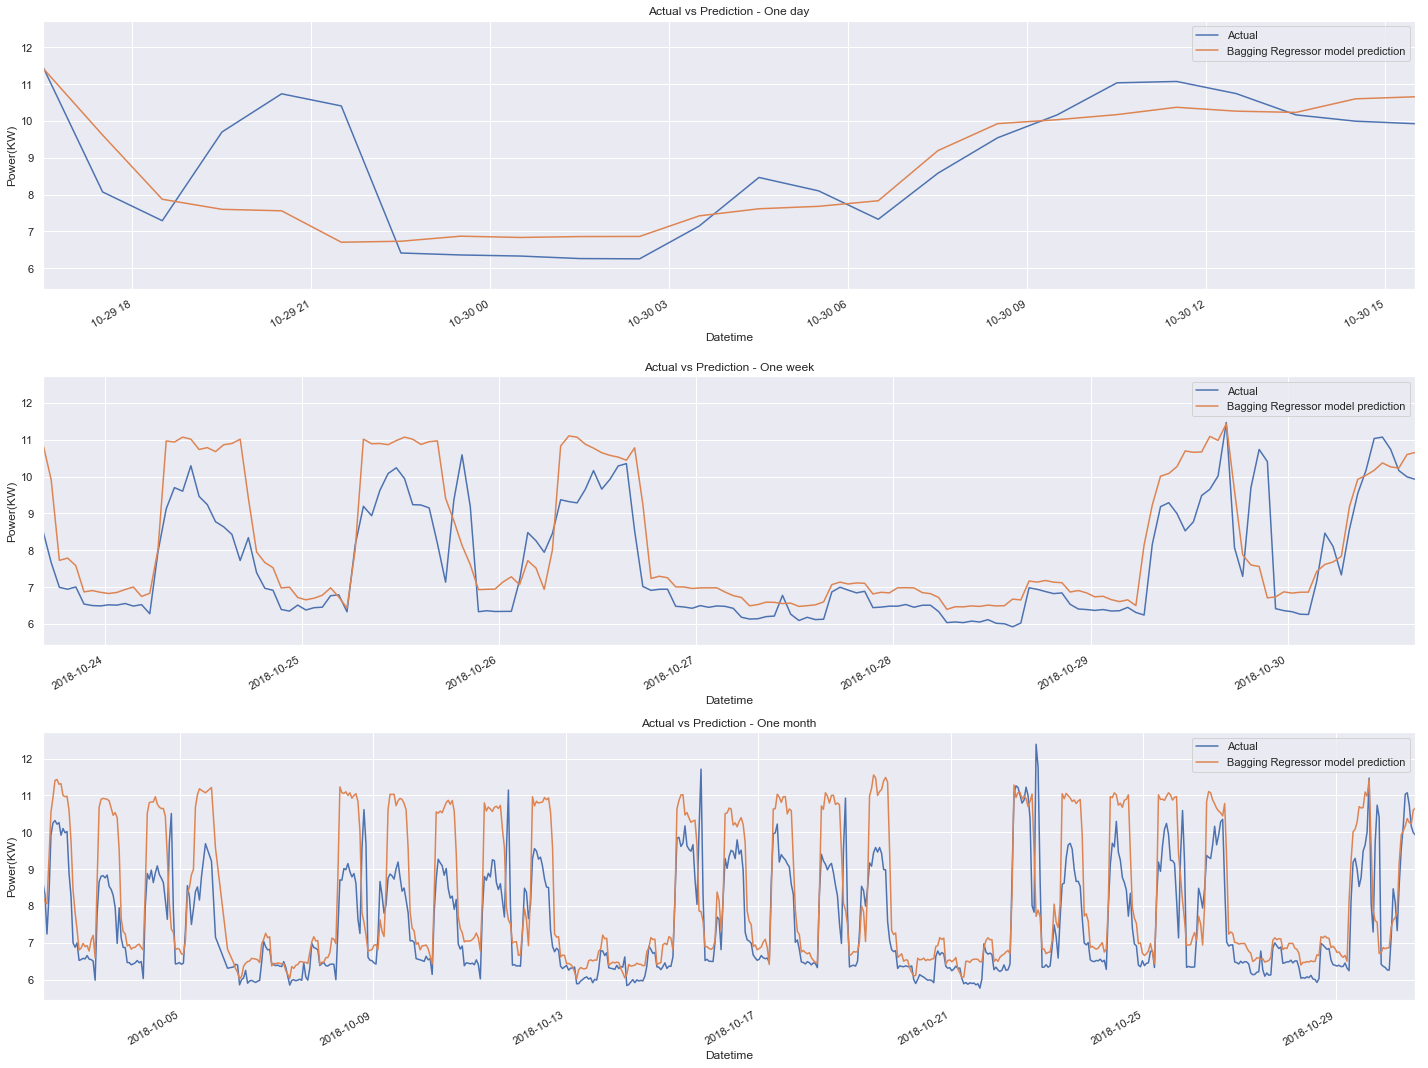

In [101]:
subplot_prediction(y_test, prediction,prediction_label='Bagging Regressor model prediction')

# Extra Trees Regressosr Model

In [102]:
reg = ExtraTreesRegressor()
reg.fit(X_train,y_train)
y_predict=reg.predict(X_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_EXGB=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_EXGB)+" percent in EXGB Regression")

Y_test=reg.predict(X_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_EXGB=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_EXGB)+" percent in EXGB Regression")

Train error = 19.97171115758839 percent in EXGB Regression
Test error = 7.090919373206854 percent in EXGB Regression


In [103]:
tscv = TimeSeriesSplit(n_splits=20)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f " % (scores.mean()*100))
print(scores)

Accuracy: 45.68 
[ 0.8390846  -0.17922395  0.52722114  0.80478391  0.80584577  0.44372879
  0.32831423  0.78702001  0.2534624   0.74186297 -1.58796576  0.3414528
  0.43061297  0.72952418  0.74447561  0.74939407  0.5805826   0.14594317
  0.83446731  0.81478562]


In [104]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
print("R2 Score :%0.2f "% r2_score(y_test,prediction))

R2 Score :0.59 


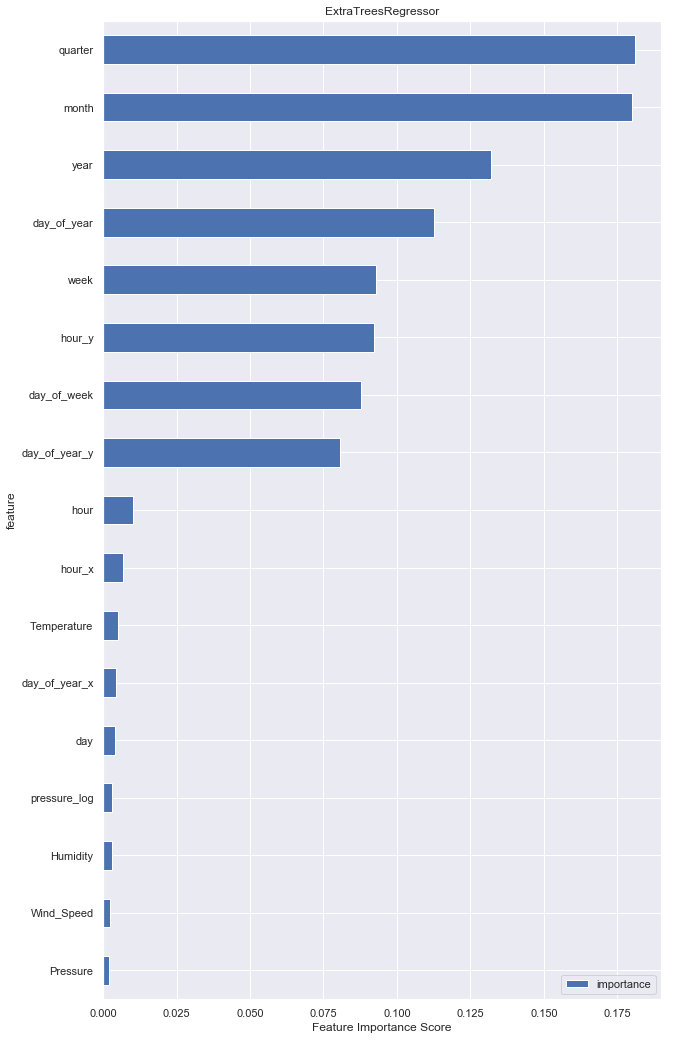

In [105]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__)

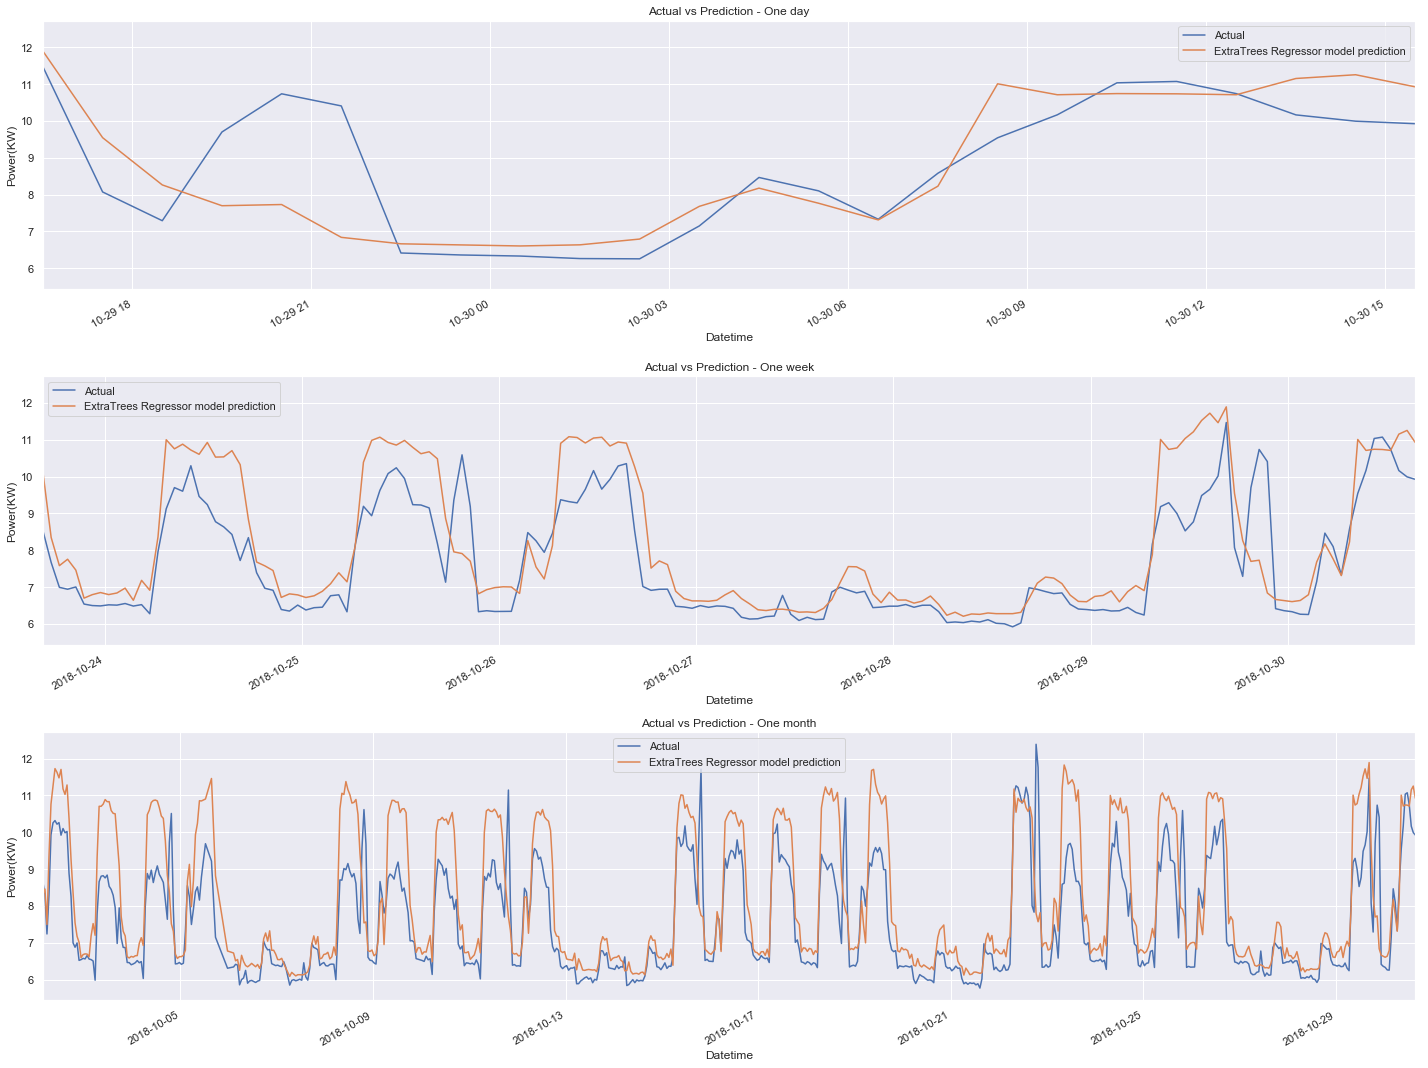

In [106]:
subplot_prediction(y_test, prediction,prediction_label='ExtraTrees Regressor model prediction')

## Multistep Prediction

In [107]:
final_df.head()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Datetime,,,,,,,,,,,,,,,,,,,
2017-02-06 07:30:00,26.597063,21.7,760.0,62.0,7.0,6.633318,0,2017,2,6,37,6,Monday,1,7,0.965926,-0.258819,0.594727,0.803928
2017-02-06 08:30:00,30.096608,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,8,0.866025,-0.500000,0.594727,0.803928
2017-02-06 09:30:00,30.744339,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,9,0.707107,-0.707107,0.594727,0.803928
2017-02-06 10:30:00,30.696277,24.1,762.9,62.0,4.0,6.637127,0,2017,2,6,37,6,Monday,1,10,0.500000,-0.866025,0.594727,0.803928
2017-02-06 11:30:00,29.545297,26.3,763.0,51.0,4.0,6.637258,0,2017,2,6,37,6,Monday,1,11,0.258819,-0.965926,0.594727,0.803928


In [108]:
date = '2018-08-01'
weather_df.loc[date].head()

,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,
2018-08-01 00:30:00,26.8,757.2,76.0,4.0,6.629627
2018-08-01 01:30:00,26.8,757.2,76.0,4.0,6.629627
2018-08-01 02:30:00,13.3,771.2,91.0,1.0,6.647948
2018-08-01 03:30:00,13.3,771.2,91.0,1.0,6.647948
2018-08-01 04:30:00,13.3,771.2,91.0,1.0,6.647948


In [109]:
def get_features(date):
    features = weather_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                ))
    return features

In [110]:
prediction = reg.predict(get_features(date))
idx = comb_df.electric_power.loc[date].index 


In [111]:
def plot_prediction_multistep(actual, prediction, start_date, title, prediction_label):
    date_rng = pd.date_range(start=start_date, periods=24, freq='H')
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, prediction, label=prediction_label)
    plt.ylabel('Power(KW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.show()

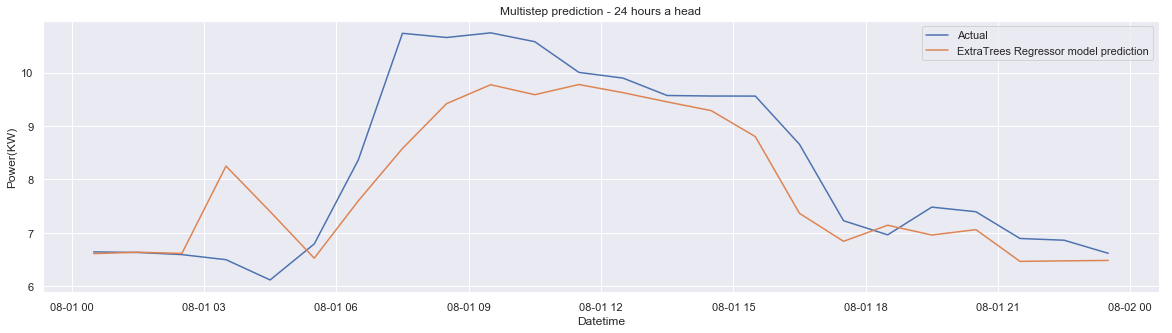

In [112]:
plot_prediction_multistep(actual=comb_df.electric_power.loc[date],prediction=prediction, start_date=date, title='Multistep prediction - 24 hours a head',
                prediction_label='ExtraTrees Regressor model prediction')

In [113]:
comb_df.tail()

,electric_power,Temperature,Pressure,Humidity,Wind_Speed,pressure_log
Datetime,,,,,,
2018-10-30 11:30:00,11.071924,27.6,764.3,48.0,4.0,6.63896
2018-10-30 12:30:00,10.741479,27.6,764.3,48.0,4.0,6.63896
2018-10-30 13:30:00,10.163620,27.6,764.3,48.0,4.0,6.63896
2018-10-30 14:30:00,9.992667,27.9,763.2,49.0,5.0,6.63752
2018-10-30 15:30:00,9.924275,27.9,763.2,49.0,5.0,6.63752
